In [1]:
import os, sys
from six.moves import cPickle
import numpy as np
import pandas as pd
import logomaker
import helper
from tfomics import utils, explain
from tensorflow import keras
from keras import backend as K
import tensorflow.compat.v1.keras.backend as K1

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:

arid3 = ['MA0151.1', 'MA0601.1', 'PB0001.1']
cebpb = ['MA0466.1', 'MA0466.2']
fosl1 = ['MA0477.1']
gabpa = ['MA0062.1', 'MA0062.2']
mafk = ['MA0496.1', 'MA0496.2']
max1 = ['MA0058.1', 'MA0058.2', 'MA0058.3']
mef2a = ['MA0052.1', 'MA0052.2', 'MA0052.3']
nfyb = ['MA0502.1', 'MA0060.1', 'MA0060.2']
sp1 = ['MA0079.1', 'MA0079.2', 'MA0079.3']
srf = ['MA0083.1', 'MA0083.2', 'MA0083.3']
stat1 = ['MA0137.1', 'MA0137.2', 'MA0137.3', 'MA0660.1', 'MA0773.1']
yy1 = ['MA0095.1', 'MA0095.2']


Gmeb1 = ['MA0615.1']

motifs = [[''],arid3, cebpb, fosl1, gabpa, mafk, max1, mef2a, nfyb, sp1, srf, stat1, yy1]
motifnames = [ '','Arid3', 'CEBPB', 'FOSL1', 'Gabpa', 'MAFK', 'MAX', 'MEF2A', 'NFYB', 
               'SP1', 'SRF', 'STAT1', 'YY1']


In [3]:

# load data
data_path = '../data/invivo_dataset.h5'
data = helper.load_dataset(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

In [4]:

num_trials = 10
model_names = ['cnn-deep', 'cnn-2', 'cnn-50']
activations = ['relu', 'exponential', 'sigmoid', 'tanh', 'selu', 'softplus', 'linear', 'elu']


results_path = utils.make_directory('../results', 'invivo')
params_path = utils.make_directory(results_path, 'model_params')
size = 32


In [5]:
model_name = model_names[0]
activation = activations[1]
trial = 0


# load model
model, name = helper.load_model(model_name, 
                                activation=activation, 
                                dropout=True, 
                                l2=1e-6, 
                                bn=True,
                                input_shape=1000)
base_name = name+'_'+activation
name = base_name+'_'+str(trial)

weights_path = os.path.join(params_path, name+'.hdf5')
model.load_weights(weights_path)

# set up optimizer and metrics
auroc = keras.metrics.AUC(curve='ROC', name='auroc')
aupr = keras.metrics.AUC(curve='PR', name='aupr')
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy', auroc, aupr])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
# save path
size=64
save_path = os.path.join('../results', 'invivo', 'conv_filters')
file_path = os.path.join(save_path, model_name+'_do_l2_bn_'+activation+'_'+str(trial), 'tomtom.tsv')
best_qvalues, best_match, min_qvalue, match_fraction  = helper.match_hits_to_ground_truth(file_path, motifs, size)


In [17]:
weights_path

'../results/invivo/model_params/cnn-deep_do_l2_bn_relu_0.hdf5'

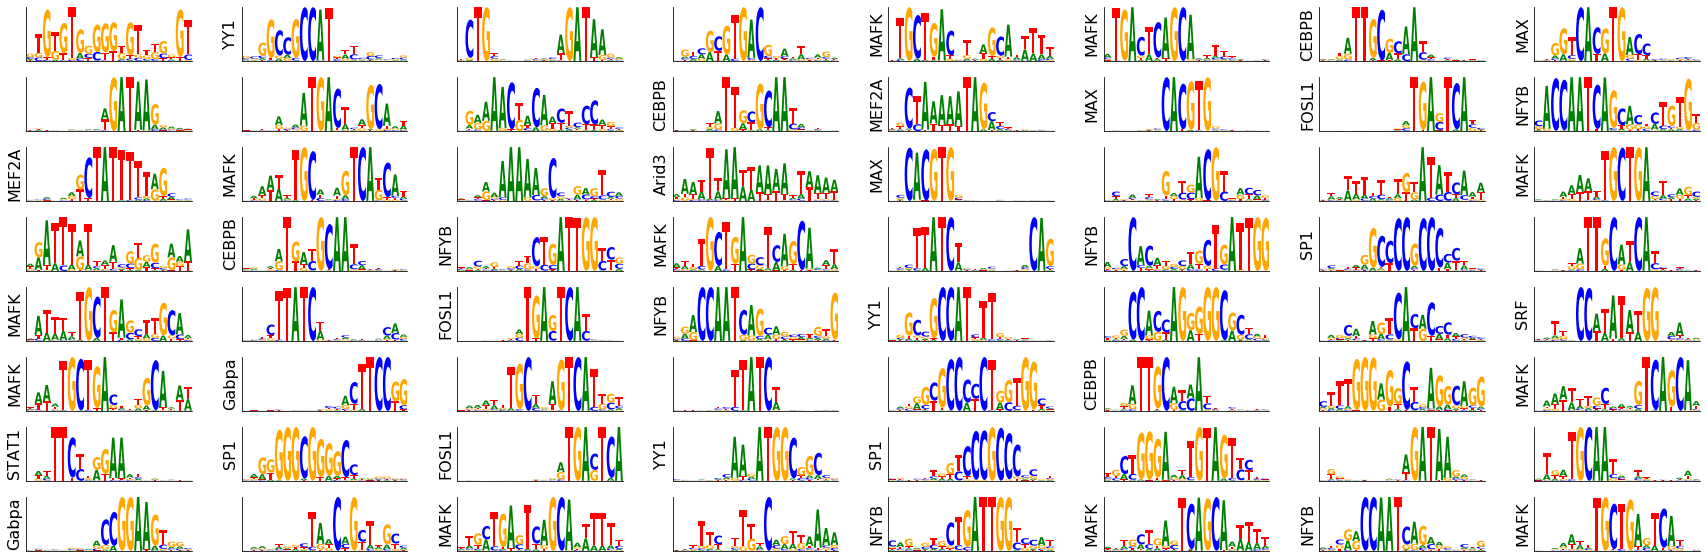

In [15]:
layer = 3
threshold = 0.5
window = 20
num_cols = 8
figsize = (30,10)


intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
fmap = intermediate.predict(x_test)
W, support = explain.activation_pwm(fmap, x_test, threshold=threshold, window=window)

num_filters = len(W)
num_widths = int(np.ceil(num_filters/num_cols))

fig = plt.figure(figsize=figsize)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for n, w in enumerate(W):
    ax = fig.add_subplot(num_widths, num_cols, n+1)
    #if (np.sum(w) != 0) | (np.sum(np.isnan(w) == True) > 0):

    # calculate sequence logo heights
    I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
    logo = I*w

    L, A = w.shape
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = logo[l,a]

    logomaker.Logo(counts_df, ax=ax)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(motifnames[int(best_match[n])], fontsize=16)


In [20]:

num_trials = 10
model_names = ['cnn-deep', 'cnn-2', 'cnn-50']
activations = ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = utils.make_directory('../results', 'invivo')
params_path = utils.make_directory(results_path, 'model_params')

layer = 3
threshold = 0.5
window = 20
num_cols = 8
figsize = (30,10)

save_path = os.path.join('../results', 'invivo', 'conv_filters')

for model_name in model_names:
    for activation in ['relu', 'exponential']:
        for trial in range(num_trials):
            # load model
            model, name = helper.load_model(model_name, 
                                            activation=activation, 
                                            dropout=True, 
                                            l2=1e-6, 
                                            bn=True,
                                            input_shape=1000)
            base_name = name+'_'+activation
            name = base_name+'_'+str(trial)
            print(name)

            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            # set up optimizer and metrics
            auroc = keras.metrics.AUC(curve='ROC', name='auroc')
            aupr = keras.metrics.AUC(curve='PR', name='aupr')
            optimizer = keras.optimizers.Adam(learning_rate=0.001)
            loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0)
            model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=['accuracy', auroc, aupr])
            # save path
            file_path = os.path.join(save_path, name, 'tomtom.tsv')
            best_qvalues, best_match, min_qvalue, match_fraction  = helper.match_hits_to_ground_truth(file_path, motifs, size)


            intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
            fmap = intermediate.predict(x_test)
            W, support = explain.activation_pwm(fmap, x_test, threshold=threshold, window=window)

            num_filters = len(W)
            num_widths = int(np.ceil(num_filters/num_cols))

            fig = plt.figure(figsize=figsize)
            fig.subplots_adjust(hspace=0.3, wspace=0.3)

            for n, w in enumerate(W):
                ax = fig.add_subplot(num_widths, num_cols, n+1)
                #if (np.sum(w) != 0) | (np.sum(np.isnan(w) == True) > 0):

                # calculate sequence logo heights
                I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
                logo = I*w

                L, A = w.shape
                counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
                for a in range(A):
                    for l in range(L):
                        counts_df.iloc[l,a] = logo[l,a]

                logomaker.Logo(counts_df, ax=ax)
                ax = plt.gca()
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                ax.yaxis.set_ticks_position('none')
                ax.xaxis.set_ticks_position('none')
                plt.xticks([])
                plt.yticks([])
                plt.ylabel(motifnames[int(best_match[n])], fontsize=16)

            outfile = os.path.join(save_path, 'label_'+name+'.pdf')
            fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
            plt.close()

cnn-deep_do_l2_bn_relu_0
cnn-deep_do_l2_bn_relu_1
cnn-deep_do_l2_bn_relu_2
cnn-deep_do_l2_bn_relu_3
cnn-deep_do_l2_bn_relu_4
cnn-deep_do_l2_bn_relu_5
cnn-deep_do_l2_bn_relu_6
cnn-deep_do_l2_bn_relu_7
cnn-deep_do_l2_bn_relu_8
cnn-deep_do_l2_bn_relu_9
cnn-deep_do_l2_bn_exponential_0
cnn-deep_do_l2_bn_exponential_1
cnn-deep_do_l2_bn_exponential_2
cnn-deep_do_l2_bn_exponential_3
cnn-deep_do_l2_bn_exponential_4
cnn-deep_do_l2_bn_exponential_5
cnn-deep_do_l2_bn_exponential_6
cnn-deep_do_l2_bn_exponential_7
cnn-deep_do_l2_bn_exponential_8
cnn-deep_do_l2_bn_exponential_9
cnn-2_do_l2_bn_relu_0
cnn-2_do_l2_bn_relu_1
cnn-2_do_l2_bn_relu_2
cnn-2_do_l2_bn_relu_3
cnn-2_do_l2_bn_relu_4
cnn-2_do_l2_bn_relu_5
cnn-2_do_l2_bn_relu_6
cnn-2_do_l2_bn_relu_7
cnn-2_do_l2_bn_relu_8
cnn-2_do_l2_bn_relu_9
cnn-2_do_l2_bn_exponential_0
cnn-2_do_l2_bn_exponential_1
cnn-2_do_l2_bn_exponential_2
cnn-2_do_l2_bn_exponential_3
cnn-2_do_l2_bn_exponential_4
cnn-2_do_l2_bn_exponential_5
cnn-2_do_l2_bn_exponential_6
cnn-2_d

In [19]:

num_trials = 10
model_names = ['cnn-deep', 'cnn-2', 'cnn-50']
activations = ['relu', 'exponential', 'selu', 'softplus', 'linear', 'elu']


results_path = utils.make_directory('../results', 'synthetic')
params_path = utils.make_directory(results_path, 'model_params')

layer = 3
threshold = 0.5
window = 20
num_cols = 8
figsize = (30,6)

save_path = os.path.join('../results', 'synthetic', 'conv_filters')

model_names = ['cnn-deep']
for model_name in model_names:
    for activation in [ 'shift_scale_tanh', 'shift_scale_sigmoid' ]:
        for trial in range(num_trials):
            # load model
            model, name = helper.load_model(model_name, 
                                            activation=activation, 
                                            dropout=True, 
                                            l2=1e-6, 
                                            bn=True,
                                            input_shape=200)
            base_name = name+'_'+activation
            name = base_name+'_'+str(trial)
            print(name)

            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            # set up optimizer and metrics
            auroc = keras.metrics.AUC(curve='ROC', name='auroc')
            aupr = keras.metrics.AUC(curve='PR', name='aupr')
            optimizer = keras.optimizers.Adam(learning_rate=0.001)
            loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0)
            model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=['accuracy', auroc, aupr])
            # save path
            file_path = os.path.join(save_path, name, 'tomtom.tsv')
            best_qvalues, best_match, min_qvalue, match_fraction  = helper.match_hits_to_ground_truth(file_path, motifs, size)


            intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
            fmap = intermediate.predict(x_test)
            W, support = explain.activation_pwm(fmap, x_test, threshold=threshold, window=window)

            num_filters = len(W)
            num_widths = int(np.ceil(num_filters/num_cols))

            fig = plt.figure(figsize=figsize)
            fig.subplots_adjust(hspace=0.3, wspace=0.3)

            for n, w in enumerate(W):
                ax = fig.add_subplot(num_widths, num_cols, n+1)
                #if (np.sum(w) != 0) | (np.sum(np.isnan(w) == True) > 0):

                # calculate sequence logo heights
                I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
                logo = I*w

                L, A = w.shape
                counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
                for a in range(A):
                    for l in range(L):
                        counts_df.iloc[l,a] = logo[l,a]

                logomaker.Logo(counts_df, ax=ax)
                ax = plt.gca()
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                ax.yaxis.set_ticks_position('none')
                ax.xaxis.set_ticks_position('none')
                plt.xticks([])
                plt.yticks([])
                plt.ylabel(motifnames[int(best_match[n])], fontsize=20)

            outfile = os.path.join(save_path, 'label_'+name+'.pdf')
            fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
            plt.close()

cnn-deep_do_l2_bn_shift_scale_tanh_0


ValueError: Error when checking input: expected input_4 to have shape (200, 4) but got array with shape (1000, 4)

[<matplotlib.lines.Line2D at 0x7f3ff0022f28>]

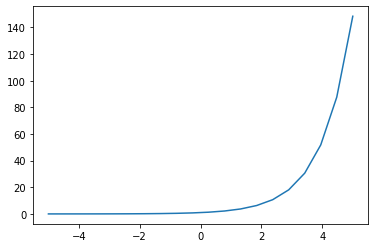

In [37]:
x = np.linspace(-5,5,20)
plt.plot(x, np.exp(x))

[<matplotlib.lines.Line2D at 0x7f3f80895e80>]

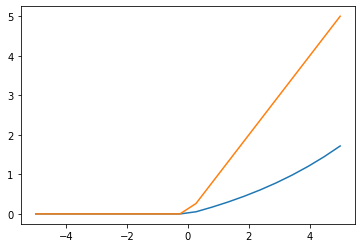

In [77]:
x = np.linspace(-5,5,20)
plt.plot(x, np.maximum(np.exp(.2*(x))-1, 0))
plt.plot(x,np.maximum(x,0))



[<matplotlib.lines.Line2D at 0x7f3f80caa198>]

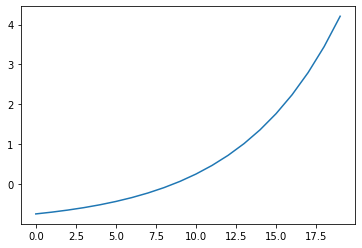

In [66]:
plt.plot(np.exp(.3*(x+.5))-1)

[<matplotlib.lines.Line2D at 0x7f3f806fce48>]

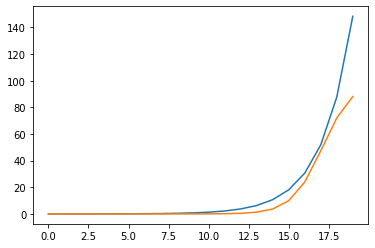

In [82]:
plt.plot(np.exp(x))
plt.plot(np.tanh(x-4)*50+50)